## Accessing Sentinel-5P data with the Planetary Computer STAC API

The Copernicus [Sentinel-5 Precursor](https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-5p) mission provides high spatio-temporal resolution measurements of the Earth's atmosphere. Sentinel-5P Level-2 data products include total columns of ozone, sulfur dioxide, nitrogen dioxide, carbon monoxide and formaldehyde, tropospheric columns of ozone, vertical profiles of ozone and cloud & aerosol information. The Planetary Computer's [`sentinel-5p-l2-netcdf`](https://planetarycomputer.microsoft.com/dataset/sentinel-5p-l2-netcdf) STAC Collection contains Items for thirteen Sentinel-5P Level-2 products in NetCDF format:

* [`L2__AER_AI`](http://www.tropomi.eu/data-products/uv-aerosol-index): Ultraviolet aerosol index
* [`L2__AER_LH`](http://www.tropomi.eu/data-products/aerosol-layer-height): Aerosol layer height
* [`L2__CH4___`](http://www.tropomi.eu/data-products/methane): Methane (CH<sub>4</sub>) total column
* [`L2__CLOUD_`](http://www.tropomi.eu/data-products/cloud): Cloud fraction, albedo, and top pressure
* [`L2__CO____`](http://www.tropomi.eu/data-products/carbon-monoxide): Carbon monoxide (CO) total column
* [`L2__HCHO__`](http://www.tropomi.eu/data-products/formaldehyde): Formaldehyde (HCHO) total column
* [`L2__NO2___`](http://www.tropomi.eu/data-products/nitrogen-dioxide): Nitrogen dioxide (NO<sub>2</sub>) total column
* [`L2__O3____`](http://www.tropomi.eu/data-products/total-ozone-column): Ozone (O<sub>3</sub>) total column
* [`L2__O3_TCL`](http://www.tropomi.eu/data-products/tropospheric-ozone-column): Ozone (O<sub>3</sub>) tropospheric column
* [`L2__SO2___`](http://www.tropomi.eu/data-products/sulphur-dioxide): Sulfur dioxide (SO<sub>2</sub>) total column
* [`L2__NP_BD3`](http://www.tropomi.eu/data-products/auxiliary): Cloud from the Suomi NPP mission, band 3
* [`L2__NP_BD6`](http://www.tropomi.eu/data-products/auxiliary): Cloud from the Suomi NPP mission, band 6
* [`L2__NP_BD7`](http://www.tropomi.eu/data-products/auxiliary): Cloud from the Suomi NPP mission, band 7

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. If you are using the [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) to run this notebook, then your API key is automatically set to the environment variable `PC_SDK_SUBSCRIPTION_KEY` for you when your server is started. Otherwise, you can view your keys by signing in to the [developer portal](https://planetarycomputer.developer.azure-api.net/). The API key may be manually set via the environment variable `PC_SDK_SUBSCRIPTION_KEY` or the following code:

```python
import planetary_computer
planetary_computer.settings.set_subscription_key(<YOUR API Key>)
```

In [81]:
import cartopy.crs as ccrs
import fsspec
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import planetary_computer
import pystac_client
import xarray as xr

### Data access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [82]:
catalog = pystac_client.Client.open(
    # "https://planetarycomputer.microsoft.com/api/stac/v1"
    "https://pct-apis-staging.westeurope.cloudapp.azure.com/stac",
    modifier=planetary_computer.sign_inplace,
)

In [83]:
collection = catalog.get_collection("sentinel-5p-l2-netcdf")
collection

id: sentinel-5p-l2-netcdf
title: Sentinel-5P Level-2
"description: The Copernicus [Sentinel-5 Precursor](https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-5p) mission provides high spatio-temporal resolution measurements of the Earth's atmosphere. The mission consists of one satellite carrying the [TROPOspheric Monitoring Instrument](http://www.tropomi.eu/) (TROPOMI). The satellite flies in loose formation with NASA's [Suomi NPP](https://www.nasa.gov/mission_pages/NPP/main/index.html) spacecraft, allowing utilization of co-located cloud mask data provided by the [Visible Infrared Imaging Radiometer Suite](https://www.nesdis.noaa.gov/current-satellite-missions/currently-flying/joint-polar-satellite-system/visible-infrared-imaging) (VIIRS) instrument onboard Suomi NPP during processing of the TROPOMI methane product. The Sentinel-5 Precursor mission aims to reduce the global atmospheric data gap between the retired [ENVISAT](https://earth.esa.int/eogateway/missions/envisat) and [AURA](https://www.nasa.gov/mission_pages/aura/main/index.html) missions and the future [Sentinel-5](https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-5) mission. Sentinel-5 Precursor [Level 2 data](http://www.tropomi.eu/data-products/level-2-products) provide total columns of ozone, sulfur dioxide, nitrogen dioxide, carbon monoxide and formaldehyde, tropospheric columns of ozone, vertical profiles of ozone and cloud & aerosol information. These measurements are used for improving air quality forecasts and monitoring the concentrations of atmospheric constituents. This STAC Collection provides Sentinel-5 Precursor Level 2 data, in NetCDF format, since April 2018 for the following products: * [`L2__AER_AI`](http://www.tropomi.eu/data-products/uv-aerosol-index): Ultraviolet aerosol index * [`L2__AER_LH`](http://www.tropomi.eu/data-products/aerosol-layer-height): Aerosol layer height * [`L2__CH4___`](http://www.tropomi.eu/data-products/methane): Methane (CH4) total column * [`L2__CLOUD_`](http://www.tropomi.eu/data-products/cloud): Cloud fraction, albedo, and top pressure * [`L2__CO____`](http://www.tropomi.eu/data-products/carbon-monoxide): Carbon monoxide (CO) total column * [`L2__HCHO__`](http://www.tropomi.eu/data-products/formaldehyde): Formaldehyde (HCHO) total column * [`L2__NO2___`](http://www.tropomi.eu/data-products/nitrogen-dioxide): Nitrogen dioxide (NO2) total column * [`L2__O3____`](http://www.tropomi.eu/data-products/total-ozone-column): Ozone (O3) total column * [`L2__O3_TCL`](http://www.tropomi.eu/data-products/tropospheric-ozone-column): Ozone (O3) tropospheric column * [`L2__SO2___`](http://www.tropomi.eu/data-products/sulphur-dioxide): Sulfur dioxide (SO2) total column * [`L2__NP_BD3`](http://www.tropomi.eu/data-products/auxiliary): Cloud from the Suomi NPP mission, band 3 * [`L2__NP_BD6`](http://www.tropomi.eu/data-products/auxiliary): Cloud from the Suomi NPP mission, band 6 * [`L2__NP_BD7`](http://www.tropomi.eu/data-products/auxiliary): Cloud from the Suomi NPP mission, band 7"
"providers: ESA (producer, processor, licensor) Microsoft (host)"
type: Collection
"item_assets: {'co': {'type': 'application/x-netcdf', 'roles': ['data'], 'title': 'TROPOMI/S5P L2 Carbon Monoxide Total Column'}, 'o3': {'type': 'application/x-netcdf', 'roles': ['data'], 'title': 'TROPOMI/S5P L2 Ozone Total Column'}, 'ch4': {'type': 'application/x-netcdf', 'roles': ['data'], 'title': 'TROPOMI/S5P L2 Methane Total Column'}, 'no2': {'type': 'application/x-netcdf', 'roles': ['data'], 'title': 'TROPOMI/S5P L2 Nitrogen Dioxide Total Column'}, 'so2': {'type': 'application/x-netcdf', 'roles': ['data'], 'title': 'TROPOMI/S5P L2 Sulphur Dioxide Total Column'}, 'hcho': {'type': 'application/x-netcdf', 'roles': ['data'], 'title': 'TROPOMI/S5P L2 Formaldehyde Total Column'}, 'cloud': {'type': 'application/x-netcdf', 'roles': ['data'], 'title': 'TROPOMI/S5P L2 Cloud Fraction, Albedo, and Top Pressure'}, 'aer_ai': {'type': 'application/x-netcdf', 'ro

### Select an area, time, and product type and find STAC Items

Let's search for Items containing the formaldehyde product (`L2__HCHO__`) over the country of India. We'll further limit our search to an arbitrary collection date of April 2, 2023 and only include data that has been processed "offline" (`OFFL`). The geospatial extents of `OFFL` Items are much larger than those processed in near real-time (`NRTI`).

In [84]:
latitude = 79.109
longitude = 22.746

geometry = {
    "type": "Point",
    "coordinates": [longitude, latitude],
}

filter = {
    "op": "and",
    "args": [
        {"op": "=", "args": [{"property": "s5p:processing_mode"}, "OFFL"]},
        {"op": "=", "args": [{"property": "s5p:product_type"}, "L2__HCHO__"]},
    ],
}

search = catalog.search(
    collections=collection,
    intersects=geometry,
    datetime="2023-04-02/2023-04-03",
    filter=filter,
)
items = list(search.get_items())

print(f"Found {len(items)} items:")
for item in items:
    print(
        f"ITEM ID = {item.id}, NOMINAL COLLECTION DATETIME = {item.properties['datetime']}"
    )

Found 10 items:
ITEM ID = S5P_L2_HCHO___20230403T200508_20230403T214638_28353, NOMINAL COLLECTION DATETIME = 2023-04-03T20:55:54Z
ITEM ID = S5P_L2_HCHO___20230403T182337_20230403T200508_28352, NOMINAL COLLECTION DATETIME = 2023-04-03T19:14:23Z
ITEM ID = S5P_L2_HCHO___20230403T164207_20230403T182337_28351, NOMINAL COLLECTION DATETIME = 2023-04-03T17:32:52.500000Z
ITEM ID = S5P_L2_HCHO___20230403T150036_20230403T164207_28350, NOMINAL COLLECTION DATETIME = 2023-04-03T15:51:22Z
ITEM ID = S5P_L2_HCHO___20230403T131906_20230403T150036_28349, NOMINAL COLLECTION DATETIME = 2023-04-03T14:09:52Z
ITEM ID = S5P_L2_HCHO___20230402T202401_20230402T220531_28339, NOMINAL COLLECTION DATETIME = 2023-04-02T21:14:47Z
ITEM ID = S5P_L2_HCHO___20230402T184230_20230402T202401_28338, NOMINAL COLLECTION DATETIME = 2023-04-02T19:33:16.500000Z
ITEM ID = S5P_L2_HCHO___20230402T170059_20230402T184230_28337, NOMINAL COLLECTION DATETIME = 2023-04-02T17:51:46Z
ITEM ID = S5P_L2_HCHO___20230402T151929_20230402T170059_28

Let's take a look at the first Item in the list.

In [85]:
f = fsspec.open(items[0].assets["hcho"].href).open()
ds = xr.open_dataset(f, group="PRODUCT", engine="h5netcdf")
ds

<xarray.Dataset>
Dimensions:                                              (scanline: 4173,
                                                          ground_pixel: 450,
                                                          time: 1, corner: 4,
                                                          layer: 34)
Coordinates:
  * scanline                                             (scanline) float64 0...
  * ground_pixel                                         (ground_pixel) float64 ...
  * time                                                 (time) datetime64[ns] ...
  * corner                                               (corner) float64 0.0...
  * layer                                                (layer) int32 0 ... 33
Data variables:
    latitude                                             (time, scanline, ground_pixel) float32 ...
    longitude                                            (time, scanline, ground_pixel) float32 ...
    delta_time                                           (time, scanline, ground_pixel) datetime64[ns] ...
    time_utc                                             (time, scanline) object ...
    qa_value                                             (time, scanline, ground_pixel) float32 ...
    formaldehyde_tropospheric_vertical_column            (time, scanline, ground_pixel) float32 ...
    formaldehyde_tropospheric_vertical_column_precision  (time, scanline, ground_pixel) float32 ...

Plotting the data in its native coordinate system is not very informative.

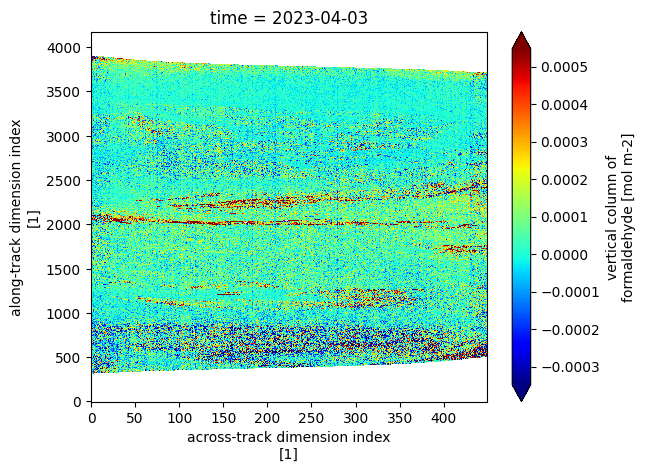

In [86]:
varname = "formaldehyde_tropospheric_vertical_column"
data = ds[varname][0, :, :]
vmin, vmax = np.nanpercentile(data, [1, 99])
data.plot(vmin=vmin, vmax=vmax, cmap="jet")

We'll plot the data in its native geographic coordinate reference system along with continent boundaries for context.

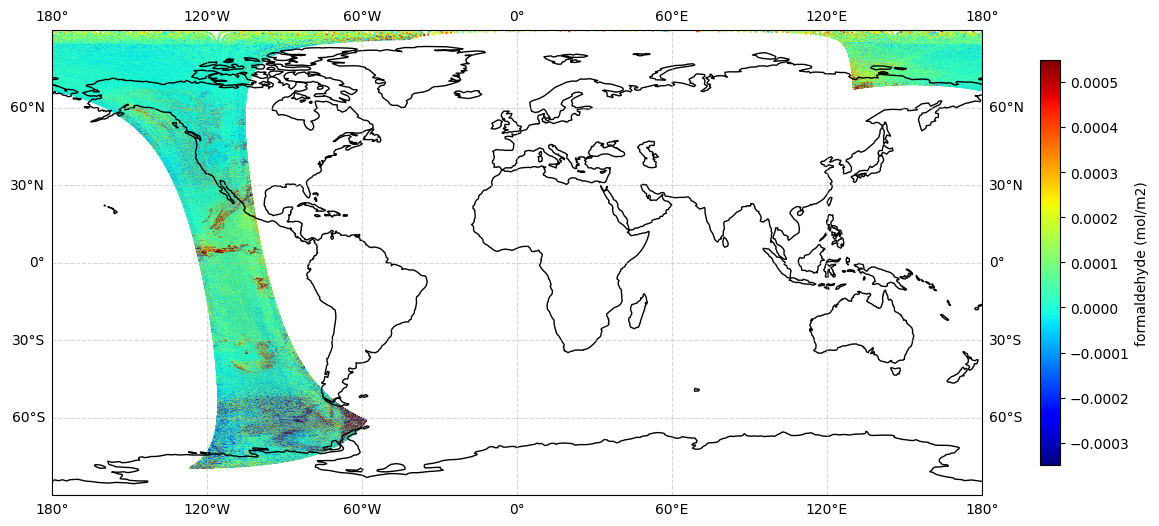

In [87]:
# formaldehyde product (NaN locations are transparent)
lon = ds["longitude"].values.squeeze()
lat = ds["latitude"].values.squeeze()
formaldehyde = data.values

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5, linestyle="--")
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
scatter = plt.scatter(
    lon,
    lat,
    c=formaldehyde,
    transform=ccrs.PlateCarree(),
    cmap="jet",
    norm=norm,
    marker=".",
    s=1,
)
fig.colorbar(scatter, pad=0.05, shrink=0.35, label="formaldehyde (mol/m2)")
plt.show()

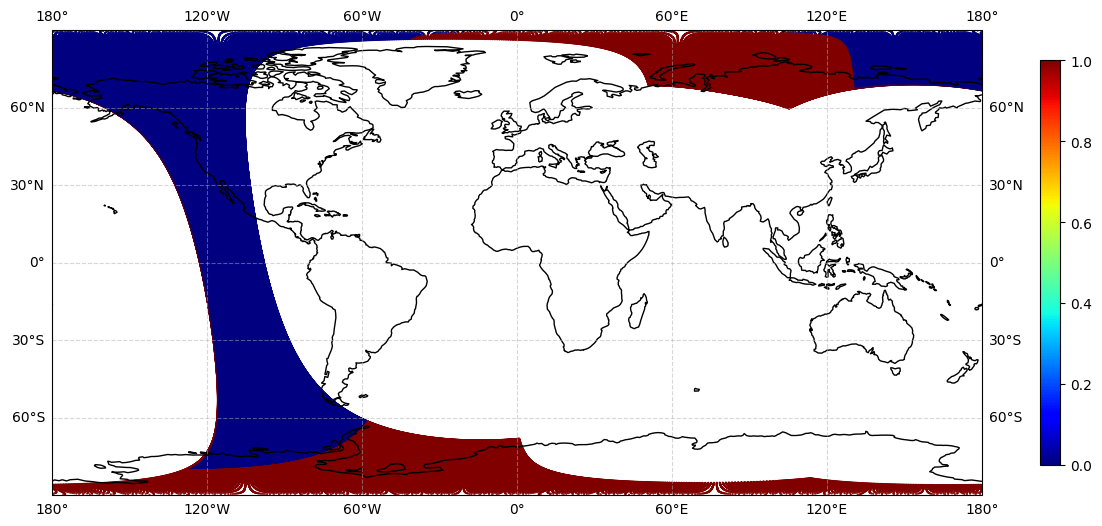

In [88]:
# showing the NaNs in red; valid data is in blue
lon = ds["longitude"].values.squeeze()
lat = ds["latitude"].values.squeeze()
formaldehyde = data.values
nan_mask = np.isnan(formaldehyde).astype(int)


fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5, linestyle="--")
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
scatter = plt.scatter(
    lon, lat, c=nan_mask, transform=ccrs.PlateCarree(), cmap="jet", marker=".", s=1
)
fig.colorbar(scatter, pad=0.05, shrink=0.35)
plt.show()

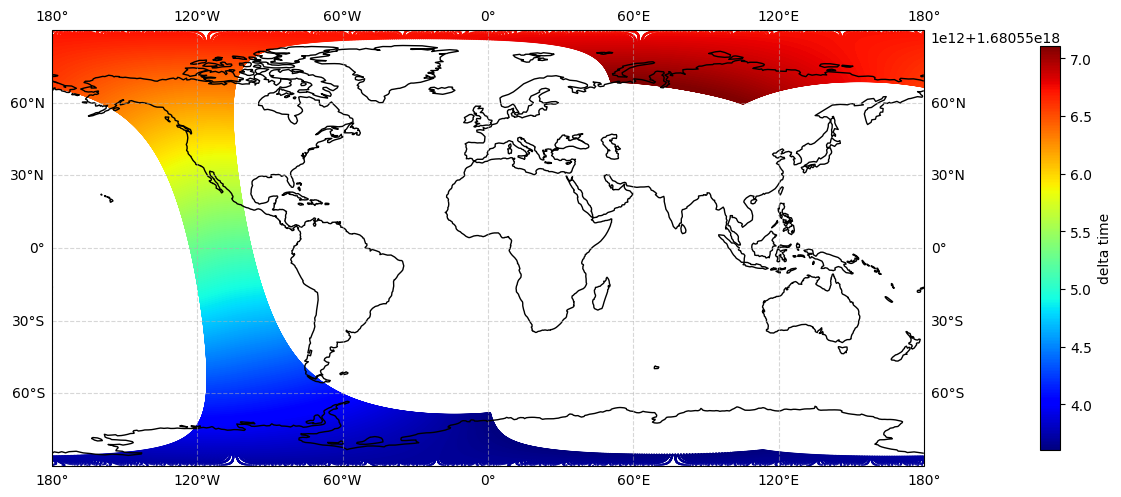

In [90]:
# Colored by time
lon = ds["longitude"].values.squeeze()
lat = ds["latitude"].values.squeeze()
delta_time = ds["delta_time"].values.squeeze().astype(int)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.5, linestyle="--")
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
scatter = plt.scatter(
    lon, lat, c=delta_time, transform=ccrs.PlateCarree(), cmap="jet", marker=".", s=1
)
fig.colorbar(scatter, pad=0.1, shrink=0.35, label="delta time")
plt.show()